In [1]:
import pandas as pd
import numpy as np
from preprocessing import DataProcessor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.metrics import confusion_matrix, accuracy_score, balanced_accuracy_score, f1_score, precision_score, roc_auc_score, roc_curve, classification_report
from sklearn.preprocessing import StandardScaler, power_transform, MinMaxScaler
from sklearn.feature_selection import  SelectKBest, chi2
from sklearn.ensemble import RandomForestClassifier
#from lightgbm import LGBMClassifier

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
heroes_information = pd.read_csv("/Users/aurelianosancho/.cache/kagglehub/datasets/claudiodavi/superhero-set/versions/1/heroes_information.csv", index_col=0)
heroes_information = heroes_information.drop_duplicates(subset='name')
super_hero_powers = pd.read_csv("/Users/aurelianosancho/.cache/kagglehub/datasets/claudiodavi/superhero-set/versions/1/super_hero_powers.csv", index_col=0)
super_hero_powers.index.name = 'name'
super_hero_powers.reset_index(inplace=True)
df = heroes_information.merge(super_hero_powers, on='name', how='inner')

In [3]:
processor = DataProcessor(heroes_information)
processor.preprocessing()
processor.normalize_min_max()
cat_heroes_information = ['Gender', 'Eye color', 'Hair color', 'Publisher']
cat_super_hero_powers = list(super_hero_powers.columns)
cat_super_hero_powers.remove('name')
cat_cols = cat_super_hero_powers + cat_heroes_information
processor.onehot_encode_columns(cat_heroes_information)
model_base = processor.df
model_base.set_index('name', inplace=True)
model_base.head(3)

,Height,Alignment,Weight,Gender_Male,Gender_Unknown,Eye color_amber,Eye color_black,Eye color_blue,Eye color_blue / white,Eye color_brown,...,Hair color_Yellow,Hair color_black,Hair color_blond,Publisher_Dark Horse Comics,Publisher_George Lucas,Publisher_Marvel Comics,Publisher_Shueisha,Publisher_Star Trek,Publisher_Team Epic TV,Publisher_Unknown
name,,,,,,,,,,,,,,,,,,,,,
Abe Sapien,0.750000,good,0.237705,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
Abin Sur,0.625000,good,0.442623,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Absorbing Man,0.791667,bad,0.704918,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [4]:
model_base.Alignment.value_counts()

Alignment
good       266
bad         99
neutral     10
Unknown      2
Name: count, dtype: int64

In [5]:
model_base = model_base[(model_base.Alignment == "good") | (model_base.Alignment == "bad") ]
model_base.Alignment.value_counts(normalize=True)

Alignment
good    0.728767
bad     0.271233
Name: proportion, dtype: float64

In [6]:
model_base['Alignment'] = model_base['Alignment'].map({'good': 1, 'bad': 0})

X = model_base.drop(['Alignment'], axis = 1)

y = model_base['Alignment']

/var/folders/vk/bfxkgyxx5lbf35sw054bmz5m0000gn/T/ipykernel_17416/4267884856.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_base['Alignment'] = model_base['Alignment'].map({'good': 1, 'bad': 0})


In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 451, test_size= .25, stratify = y)

# Naive Bayes

In [8]:
skf = StratifiedKFold(n_splits = 5, shuffle = True)

NB = cross_validate(estimator=GaussianNB(),
                    cv=skf, 
                    scoring=["accuracy", "precision_macro", "recall_macro", "f1_macro", "roc_auc"], 
                    return_estimator=True,
                    return_train_score=True,
                    verbose=2,
                    X=X_train,
                    y=y_train)

[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.1s


In [9]:
cv_df = pd.DataFrame(NB)
cv_df

,fit_time,score_time,estimator,test_accuracy,train_accuracy,test_precision_macro,train_precision_macro,test_recall_macro,train_recall_macro,test_f1_macro,train_f1_macro,test_roc_auc,train_roc_auc
0,0.011202,0.022387,GaussianNB(),0.345455,0.385321,0.559524,0.652850,0.529167,0.578616,0.327446,0.369997,0.524167,0.816864
1,0.012486,0.040062,GaussianNB(),0.272727,0.417431,0.377451,0.658602,0.458333,0.600629,0.242424,0.408356,0.635000,0.798636
2,0.003415,0.021710,GaussianNB(),0.254545,0.389908,0.291667,0.653646,0.445833,0.581761,0.217286,0.375600,0.573333,0.805458
3,0.004146,0.018719,GaussianNB(),0.351852,0.378995,0.516304,0.651282,0.510256,0.575000,0.340774,0.362718,0.676923,0.786864
4,0.015755,0.038198,GaussianNB(),0.333333,0.378995,0.640000,0.653061,0.550000,0.572327,0.309659,0.360749,0.728571,0.804507


In [10]:
teste = ['test_accuracy', 'test_precision_macro', 'test_recall_macro', 'test_f1_macro', 'test_roc_auc']
for icol in teste:
    print('%s -> mean: %1.2f +- %1.2f' %(icol, cv_df[icol].mean(), cv_df[icol].std()))

test_accuracy -> mean: 0.31 +- 0.04
test_precision_macro -> mean: 0.48 +- 0.14
test_recall_macro -> mean: 0.50 +- 0.05
test_f1_macro -> mean: 0.29 +- 0.05
test_roc_auc -> mean: 0.63 +- 0.08


Média de acurácia de treino dos modelos: 0.39013028360772484 
 Desvio padrão de acurácia de treino dos modelos: 0.01425823923249559
Média de acurácia de teste dos modelos: 0.31158249158249157 
 Desvio padrão de acurácia de teste dos modelos: 0.040012468439565956


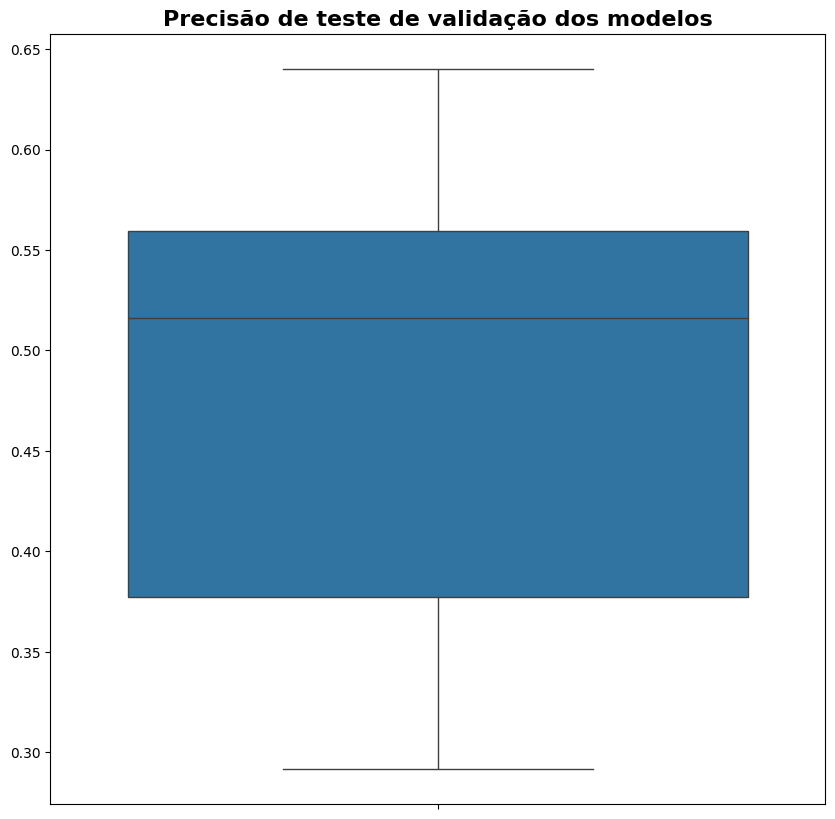

In [11]:
print("Média de acurácia de treino dos modelos:", NB["train_accuracy"].mean(), "\n", "Desvio padrão de acurácia de treino dos modelos:", NB["train_accuracy"].std())
print("Média de acurácia de teste dos modelos:", NB["test_accuracy"].mean(), "\n", "Desvio padrão de acurácia de teste dos modelos:", NB["test_accuracy"].std())

plt.figure(figsize = (10,10))
sns.boxplot(NB["test_precision_macro"])
plt.title("Precisão de teste de validação dos modelos", fontsize = 16, weight = "bold");


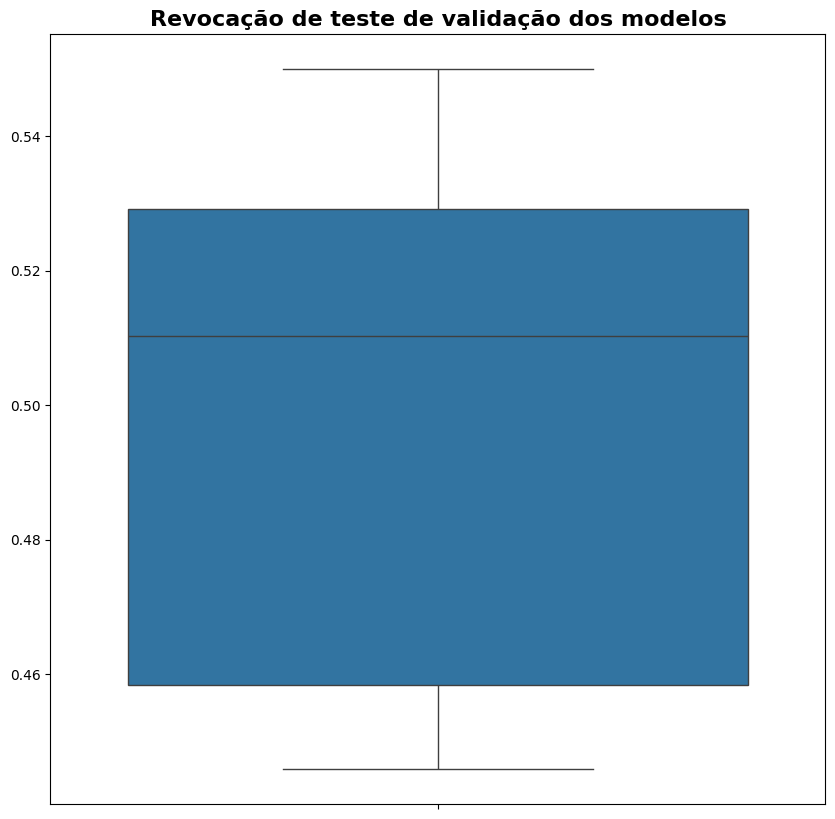

In [12]:
plt.figure(figsize = (10,10))
sns.boxplot(NB["test_recall_macro"])
plt.title("Revocação de teste de validação dos modelos", fontsize = 16, weight = "bold");

In [13]:
NB = NB["estimator"]

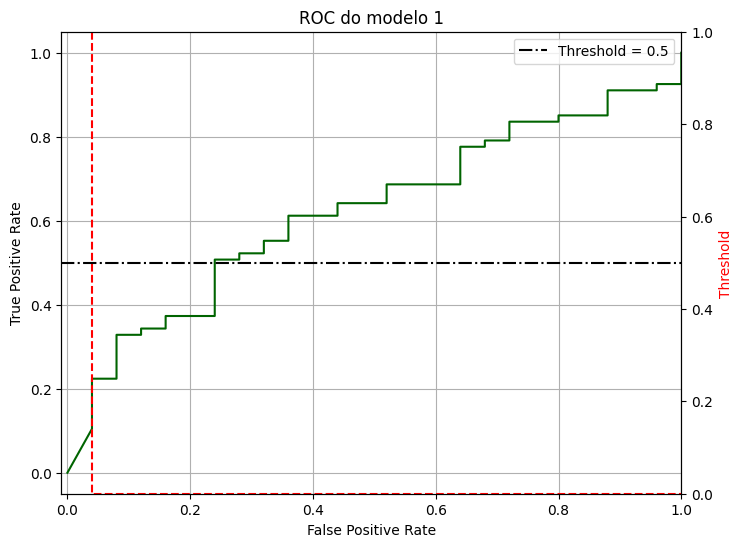

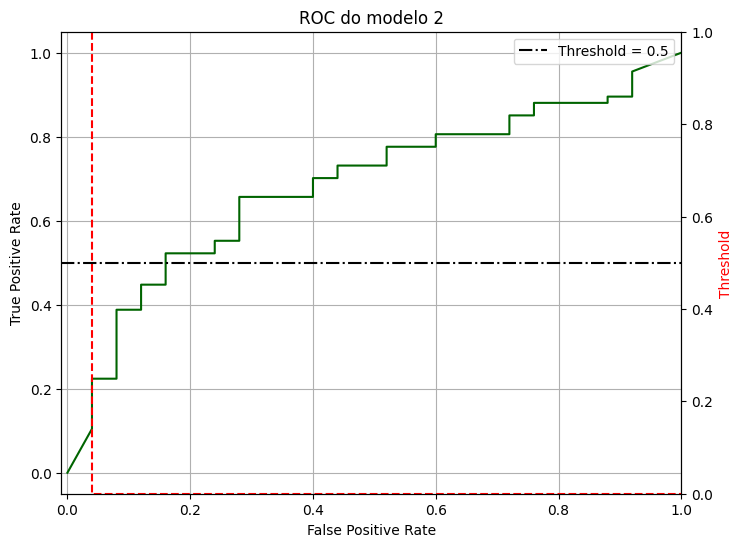

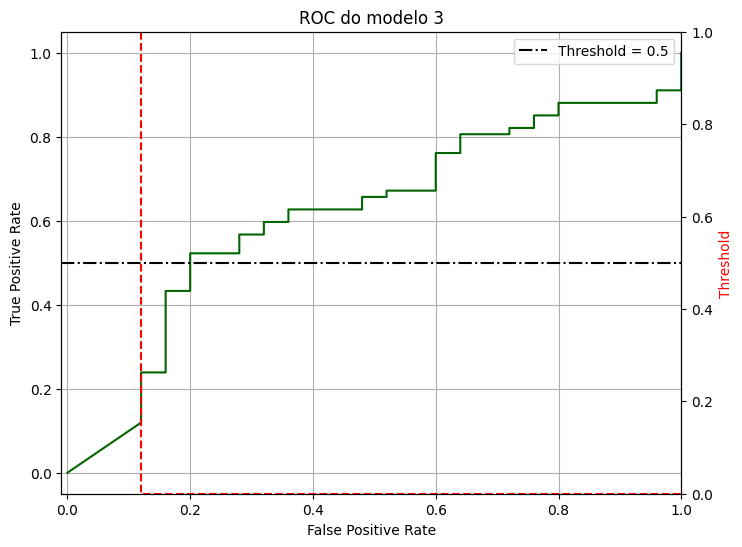

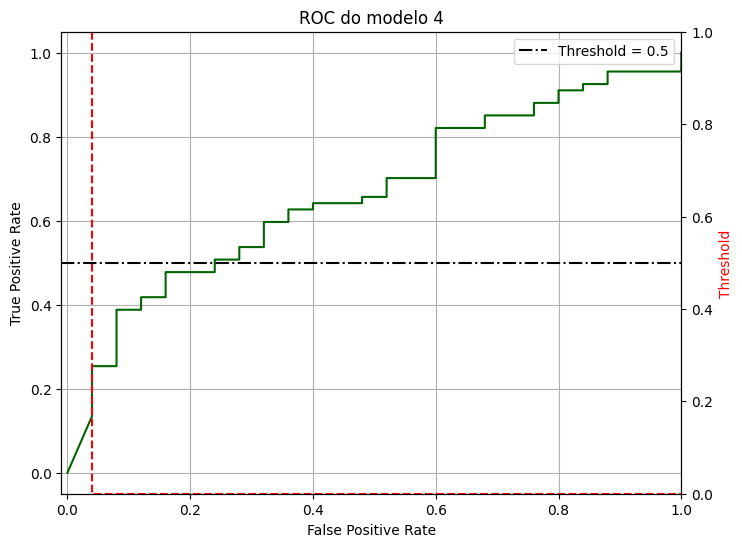

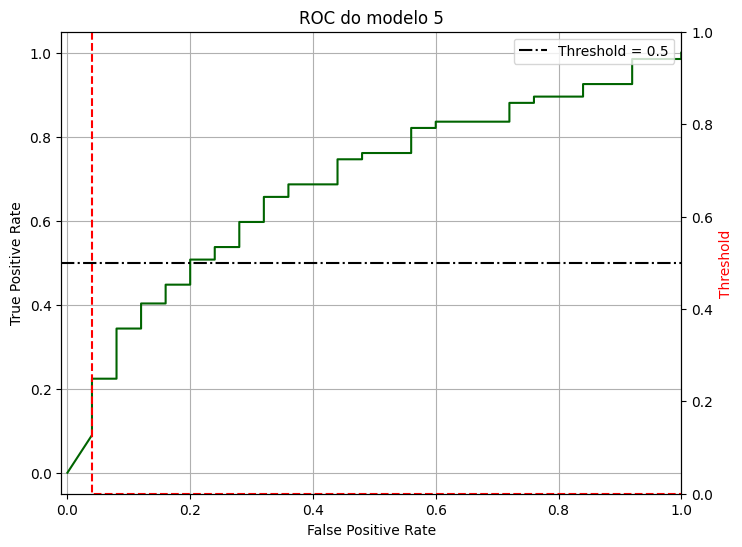

In [14]:
for i in range(5):
    y_pred_proba = NB[i].predict_proba(X_test)[::,1]
    fpr, tpr, sarrafo = roc_curve(y_test,  y_pred_proba)
    sarrafo = sarrafo[fpr <= 1]
    
    #create ROC curve
    plt.figure(figsize = (8,6))
    plt.plot(fpr,tpr, lw = 1.5, color = "darkgreen")
    plt.grid()
    plt.title(f"ROC do modelo {i + 1}")
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    ax2 = plt.gca().twinx()
    ax2.plot(fpr, sarrafo, markeredgecolor='r',linestyle='dashed', color='r')
    ax2.set_ylabel('Threshold',color='r')
    ax2.set_ylim([0,1])
    ax2.set_xlim([-0.01,1])
    ax2.axhline(y = 0.5, lw = 1.5, color = "black", ls = "-.", label = "Threshold = 0.5")
    plt.legend()

    plt.show()

In [15]:
for i in range(5):
    scores = [accuracy_score(y_test, NB[i].predict(X_test)), 
                             balanced_accuracy_score(y_test, NB[i].predict(X_test)), 
                             f1_score(y_test, NB[i].predict(X_test), average = "macro"), 
                             precision_score(y_test, NB[i].predict(X_test)), 
                             roc_auc_score(y_test, NB[i].predict(X_test))]
    scores_names = ["Acurácia", "Acurácia_balanceada", "F1_macro", "Precisão", "ROC"]
    
    print("Modelo", i + 1)
    print(pd.DataFrame([scores], columns = scores_names))

Modelo 1
   Acurácia  Acurácia_balanceada  F1_macro  Precisão       ROC
0  0.336957             0.532239  0.313517     0.875  0.532239
Modelo 2
   Acurácia  Acurácia_balanceada  F1_macro  Precisão       ROC
0  0.336957             0.532239  0.313517     0.875  0.532239
Modelo 3
   Acurácia  Acurácia_balanceada  F1_macro  Precisão       ROC
0  0.326087             0.499701  0.310111  0.727273  0.499701
Modelo 4
   Acurácia  Acurácia_balanceada  F1_macro  Precisão       ROC
0  0.358696             0.547164  0.341182       0.9  0.547164
Modelo 5
   Acurácia  Acurácia_balanceada  F1_macro  Precisão       ROC
0  0.326087             0.524776  0.299263  0.857143  0.524776


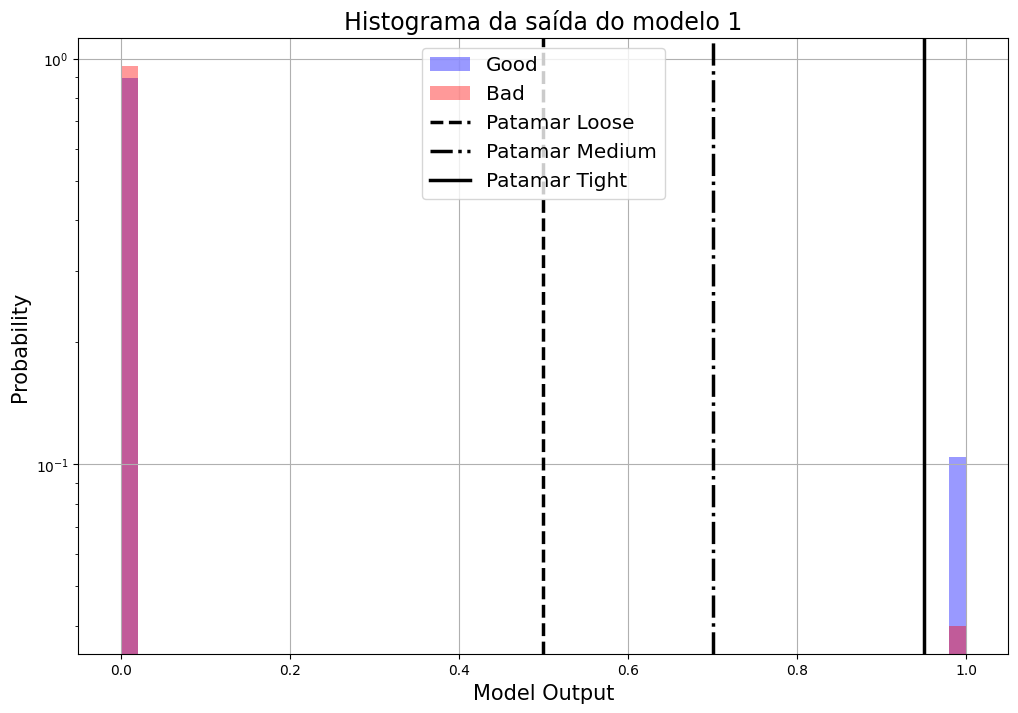

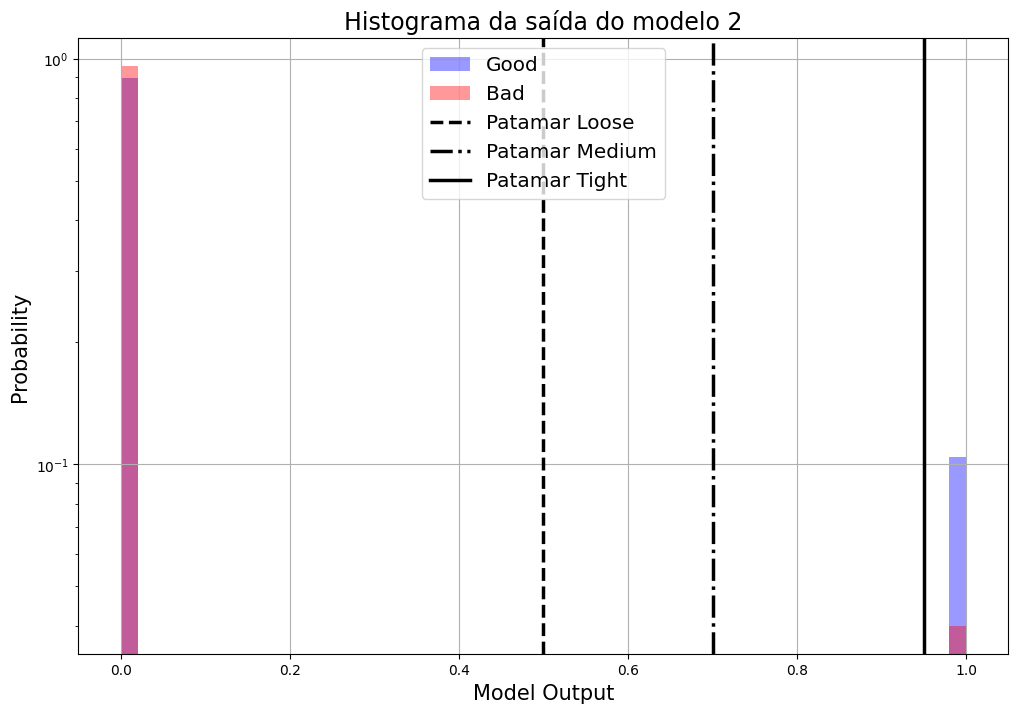

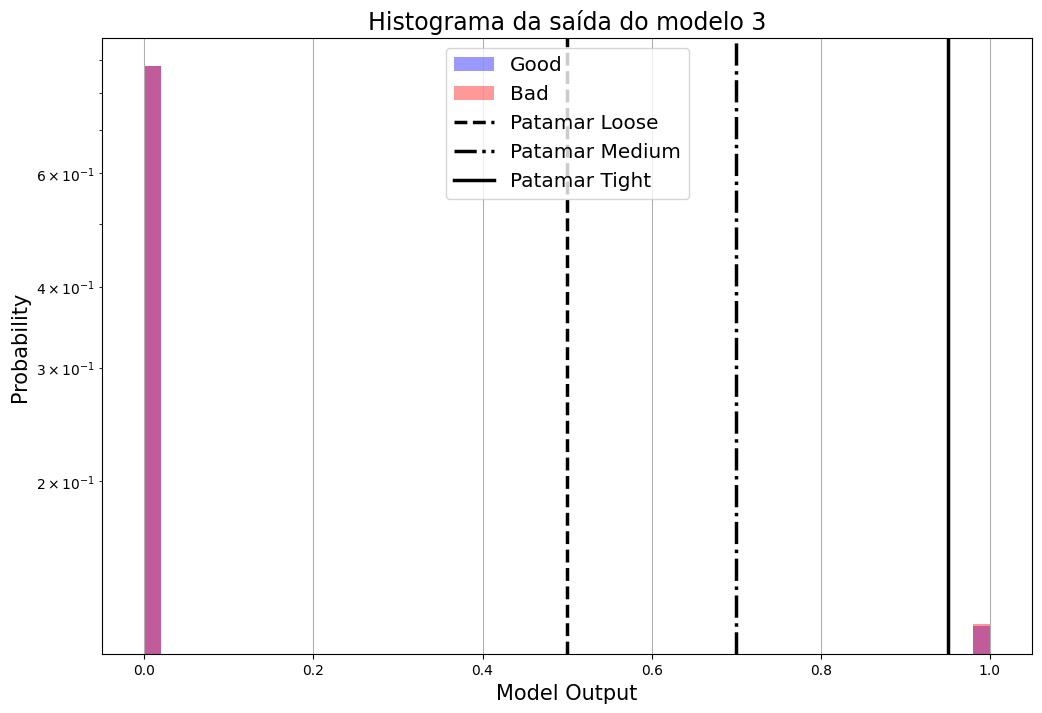

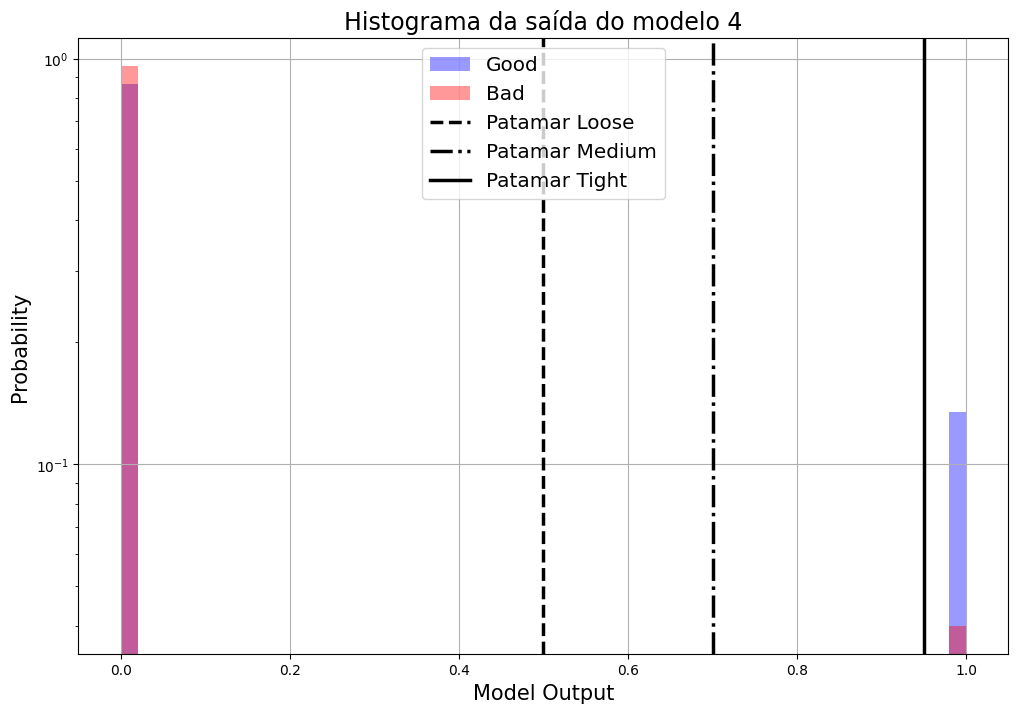

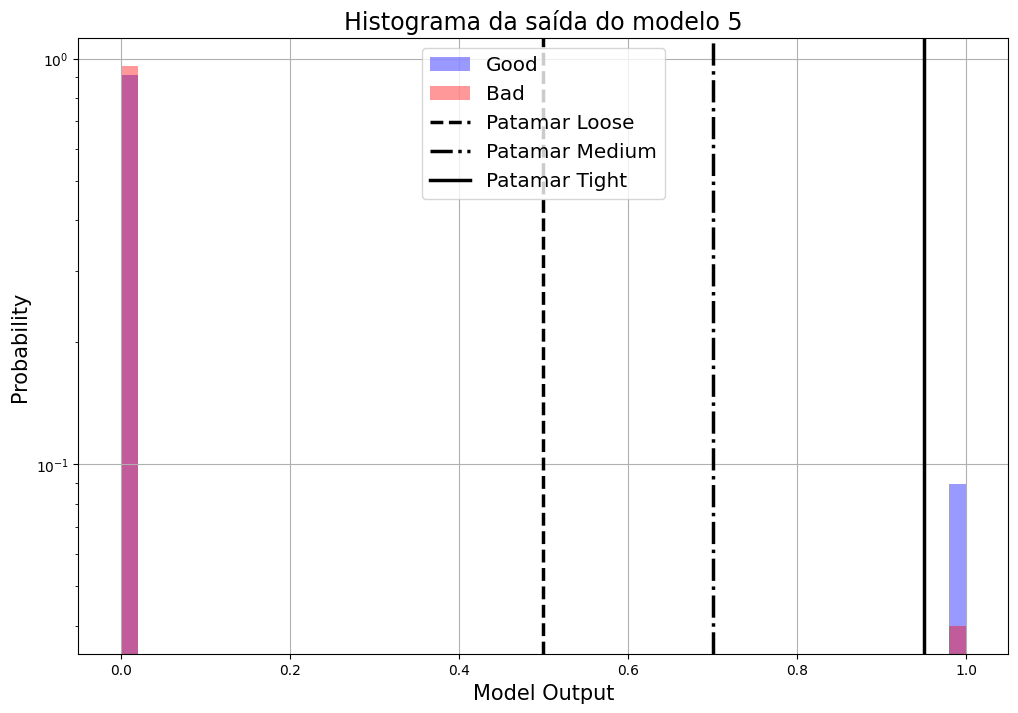

In [16]:
predict_model_cols = X_test.columns

for model_idx in range(5):
    # Separa os valores de teste
    if "probabilidade_model_%i" %(model_idx) not in X_test.columns:
        X_test["probabilidade_model_%i" %(model_idx)] = NB[model_idx].predict_proba(X_test[predict_model_cols])[:,1]
    
    #Figura
    plt.figure(figsize = (12,8))
    # weights for hist 1
    weights_h1 = (np.ones_like(X_test.loc[y_test == 1, "probabilidade_model_%i" %(model_idx)].values)/\
                  len(X_test.loc[y_test == 1, "probabilidade_model_%i" %(model_idx)]))
    # weights for hist 2
    weights_h2 = (np.ones_like(X_test.loc[y_test != 1, "probabilidade_model_%i" %(model_idx)].values)/\
                  len(X_test.loc[y_test != 1, "probabilidade_model_%i" %(model_idx)]))

    plt.hist(X_test.loc[y_test == 1, "probabilidade_model_%i" %(model_idx)], 
             label='Good', weights=weights_h1,
             color='blue', bins=50, histtype='stepfilled', lw=1.5, alpha=.4)
    plt.hist(X_test.loc[y_test != 1, "probabilidade_model_%i" %(model_idx)], 
             label='Bad', weights=weights_h2, 
             color='red', bins=50, histtype='stepfilled', lw=1.5, alpha=.4)
    #sns.histplot(x = x_test["probabilidade de pagar"],
    #             hue = y_test)
    plt.ylabel('Probability', fontsize=15)
    plt.xlabel('Model Output', fontsize=15)
    plt.grid()
    plt.title(f"Histograma da saída do modelo {model_idx+1}", fontsize=17) 
    plt.axvline(x=.5, color='black', lw=2.5, ls='--', label='Patamar Loose')
    plt.axvline(x=.7, color='black', lw=2.5, ls='-.', label='Patamar Medium')
    plt.axvline(x=.95, color='black', lw=2.5, ls='-', label='Patamar Tight')
    plt.legend(loc='upper center', fontsize='x-large')
    plt.yscale('log')
    plt.show()

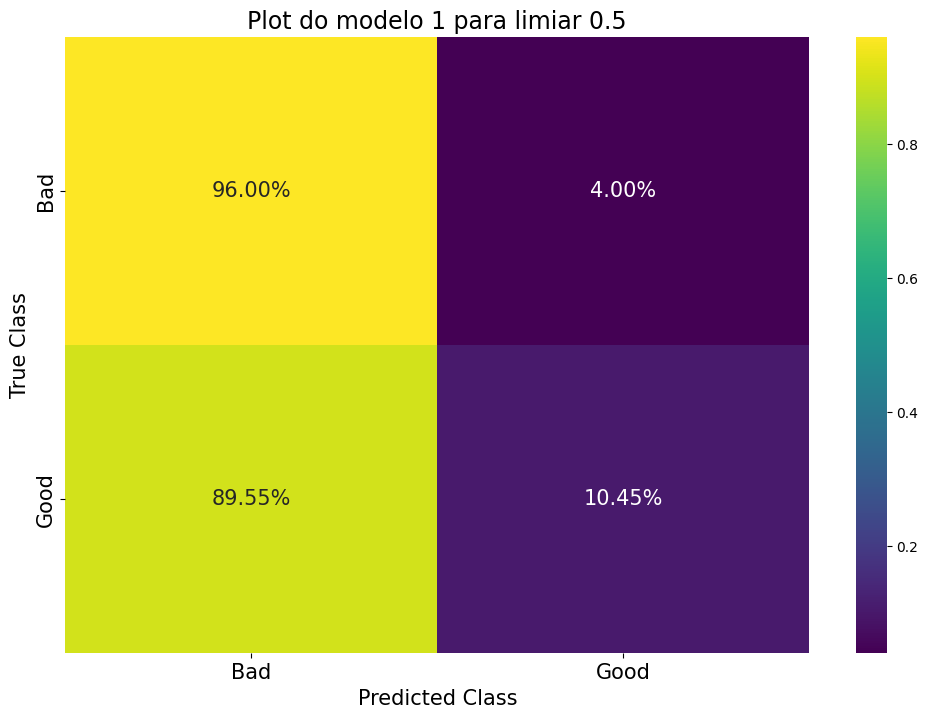

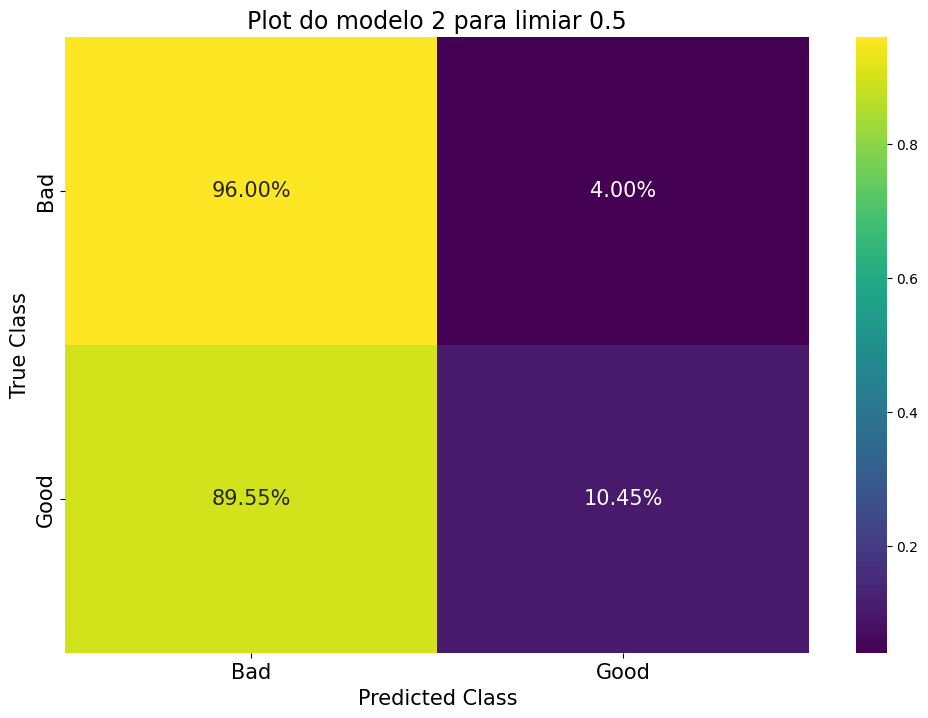

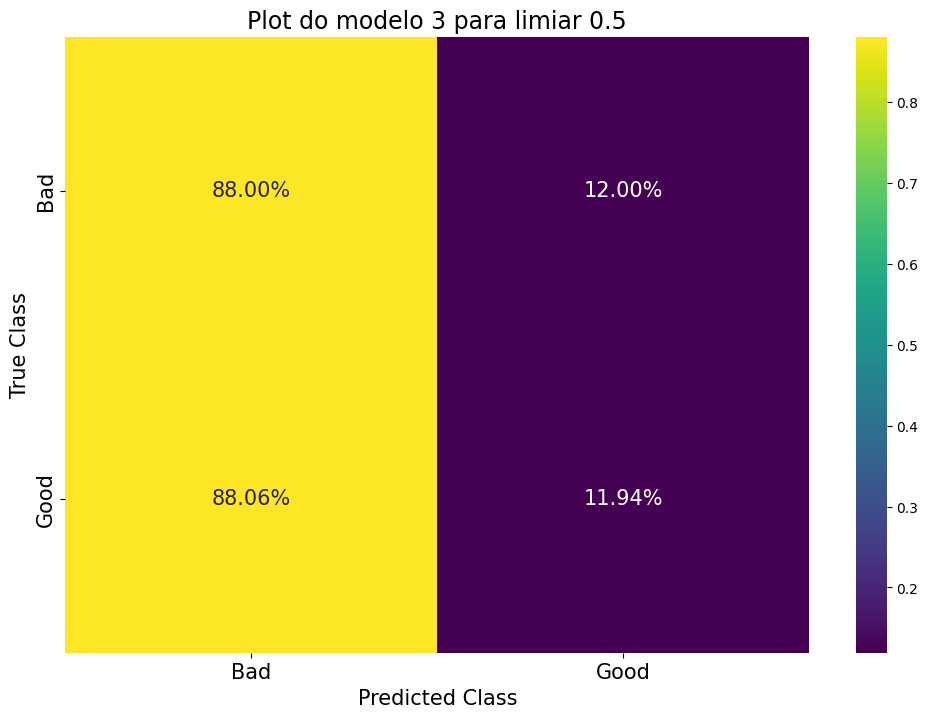

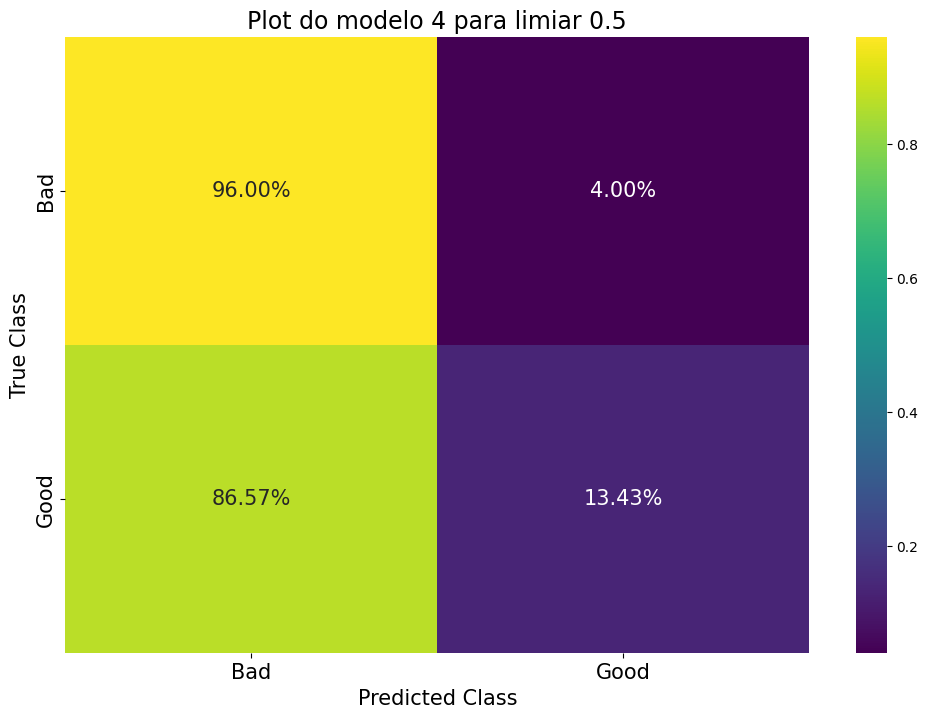

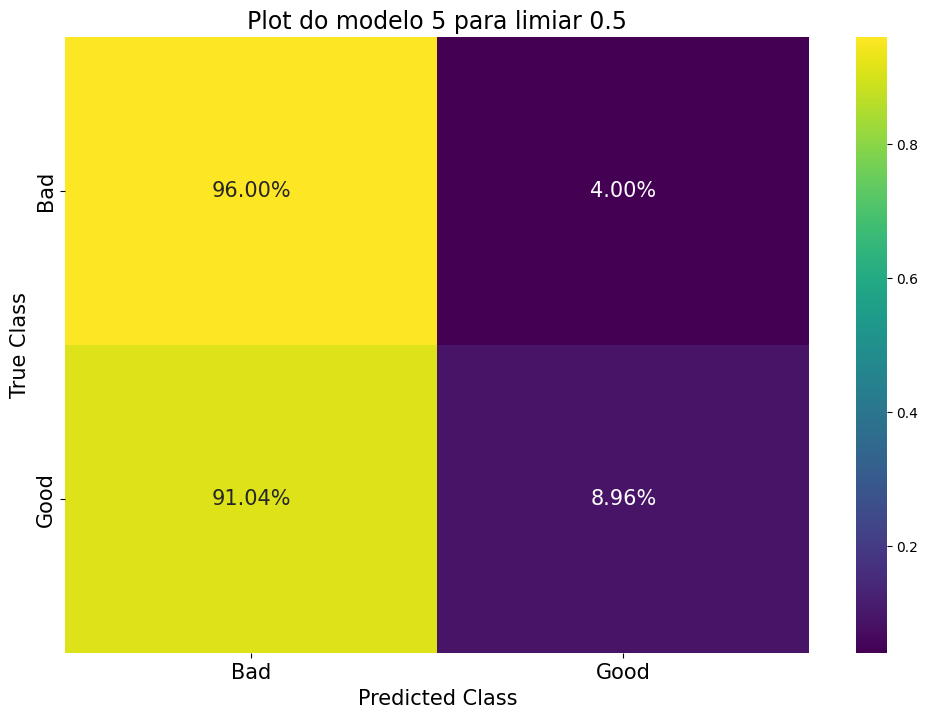

In [17]:
for i in range(5):
    plt.figure(figsize = (12,8))
    matriz = confusion_matrix(y_test, NB[i].predict(X_test[predict_model_cols]), normalize = "true")
    ax = sns.heatmap(matriz, cmap = "viridis", annot = True, annot_kws={"fontsize":15}, fmt=".2%")
    ax.set_title(f"Plot do modelo {i+1} para limiar 0.5", fontsize=17)
    ax.set_ylabel("True Class", fontsize=15)
    ax.set_xlabel("Predicted Class", fontsize=15)
    ax.set_xticklabels(["Bad", "Good"], fontsize=15)
    ax.set_yticklabels(["Bad", "Good"], fontsize=15)
    plt.show()
    "/n"

# Random Forest Classifier

In [69]:
skf = StratifiedKFold(n_splits = 5, shuffle = True)

RF = cross_validate(estimator=RandomForestClassifier(class_weight="balanced_subsample", 
                                                     n_estimators=10,            
                                                     min_samples_split=5,        
                                                     min_samples_leaf=5,         
                                                     max_depth=4,                
                                                     max_features="sqrt",        
                                                     random_state=451), 
                    cv=skf, 
                    scoring=["accuracy", "precision_macro", "recall_macro", "f1_macro", "roc_auc"], 
                    return_estimator=True,
                    return_train_score=True,
                    verbose=2,
                    X=X_train,
                    y=y_train)

[CV] END .................................................... total time=   0.2s
[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.1s


In [70]:
cv_df = pd.DataFrame(RF)
cv_df

,fit_time,score_time,estimator,test_accuracy,train_accuracy,test_precision_macro,train_precision_macro,test_recall_macro,train_recall_macro,test_f1_macro,train_f1_macro,test_roc_auc,train_roc_auc
0,0.131499,0.050194,"(DecisionTreeClassifier(max_depth=4, max_featu...",0.636364,0.692661,0.587535,0.650987,0.604167,0.682710,0.587087,0.653845,0.677500,0.747895
1,0.041095,0.022370,"(DecisionTreeClassifier(max_depth=4, max_featu...",0.472727,0.688073,0.569659,0.675981,0.575000,0.722204,0.472029,0.666036,0.545833,0.786430
2,0.026175,0.016233,"(DecisionTreeClassifier(max_depth=4, max_featu...",0.672727,0.738532,0.600619,0.679440,0.608333,0.698167,0.603365,0.686236,0.625000,0.768841
3,0.030500,0.026683,"(DecisionTreeClassifier(max_depth=4, max_featu...",0.740741,0.689498,0.691729,0.668939,0.717949,0.712606,0.699523,0.663382,0.703419,0.778814
4,0.035310,0.017264,"(DecisionTreeClassifier(max_depth=4, max_featu...",0.685185,0.684932,0.652875,0.651056,0.694643,0.684434,0.650552,0.651314,0.750893,0.758333


In [71]:
teste = ['test_accuracy', 'test_precision_macro', 'test_recall_macro', 'test_f1_macro', 'test_roc_auc']
for icol in teste:
    print('%s -> mean: %1.2f +- %1.2f' %(icol, cv_df[icol].mean(), cv_df[icol].std()))

test_accuracy -> mean: 0.64 +- 0.10
test_precision_macro -> mean: 0.62 +- 0.05
test_recall_macro -> mean: 0.64 +- 0.06
test_f1_macro -> mean: 0.60 +- 0.09
test_roc_auc -> mean: 0.66 +- 0.08


Média de acurácia de treino dos modelos: 0.6987390557580329 
 Desvio padrão de acurácia de treino dos modelos: 0.020051147004083624
Média de acurácia de teste dos modelos: 0.6415488215488215 
 Desvio padrão de acurácia de teste dos modelos: 0.09082165641979836


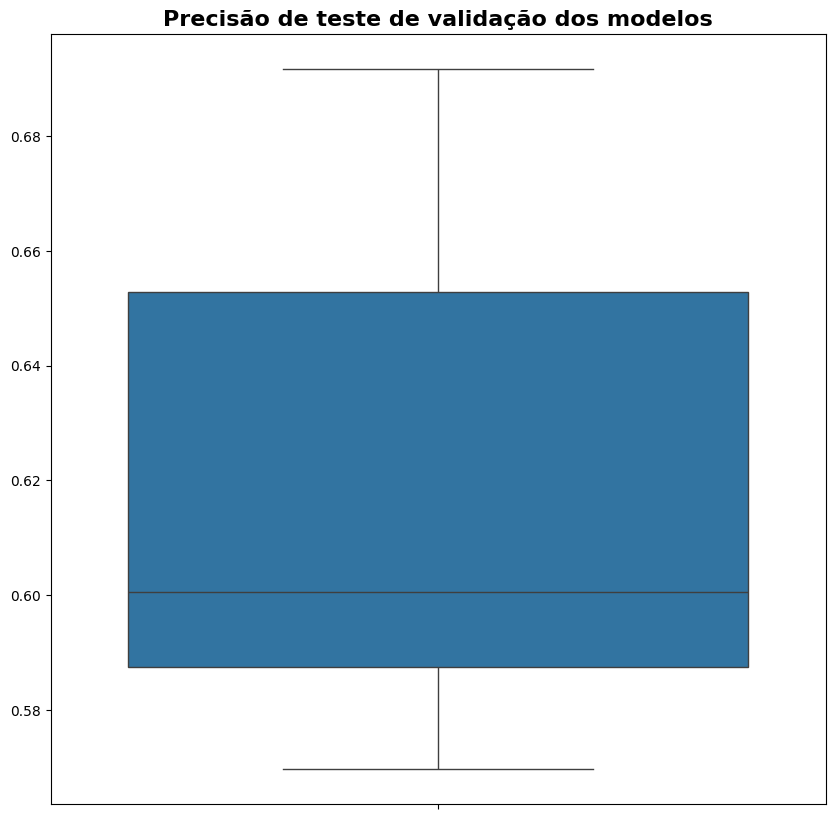

In [72]:
print("Média de acurácia de treino dos modelos:", RF["train_accuracy"].mean(), "\n", "Desvio padrão de acurácia de treino dos modelos:", RF["train_accuracy"].std())
print("Média de acurácia de teste dos modelos:", RF["test_accuracy"].mean(), "\n", "Desvio padrão de acurácia de teste dos modelos:", RF["test_accuracy"].std())

plt.figure(figsize = (10,10))
sns.boxplot(RF["test_precision_macro"])
plt.title("Precisão de teste de validação dos modelos", fontsize = 16, weight = "bold");


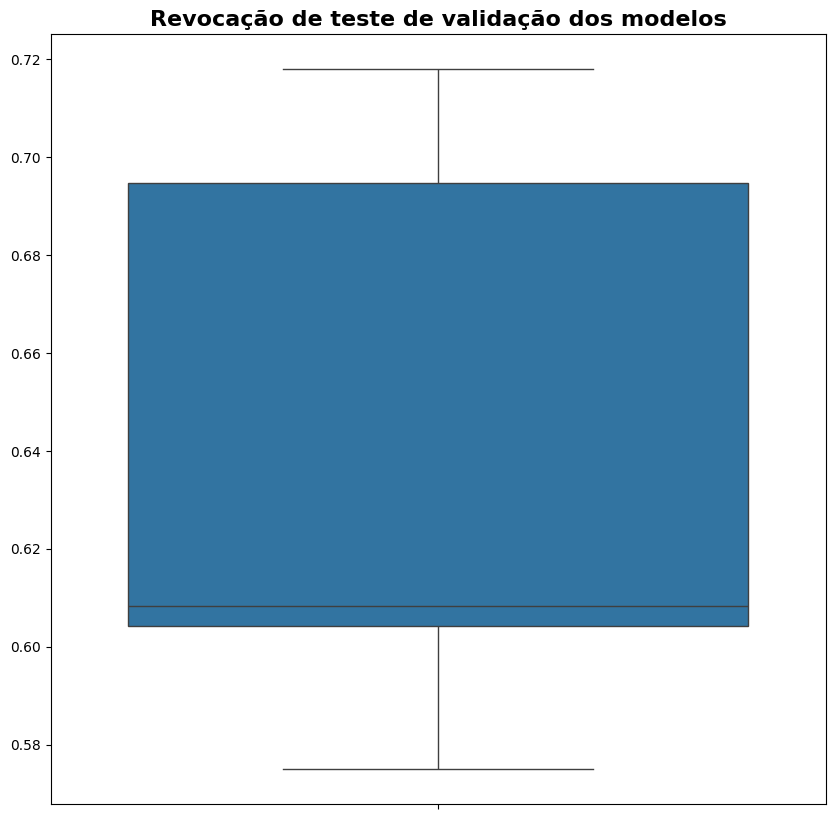

In [73]:
plt.figure(figsize = (10,10))
sns.boxplot(RF["test_recall_macro"])
plt.title("Revocação de teste de validação dos modelos", fontsize = 16, weight = "bold");

In [74]:
RF = RF["estimator"]
RF

[RandomForestClassifier(class_weight='balanced_subsample', max_depth=4,
                        min_samples_leaf=5, min_samples_split=5, n_estimators=10,
                        random_state=451),
 RandomForestClassifier(class_weight='balanced_subsample', max_depth=4,
                        min_samples_leaf=5, min_samples_split=5, n_estimators=10,
                        random_state=451),
 RandomForestClassifier(class_weight='balanced_subsample', max_depth=4,
                        min_samples_leaf=5, min_samples_split=5, n_estimators=10,
                        random_state=451),
 RandomForestClassifier(class_weight='balanced_subsample', max_depth=4,
                        min_samples_leaf=5, min_samples_split=5, n_estimators=10,
                        random_state=451),
 RandomForestClassifier(class_weight='balanced_subsample', max_depth=4,
                        min_samples_leaf=5, min_samples_split=5, n_estimators=10,
                        random_state=451)]

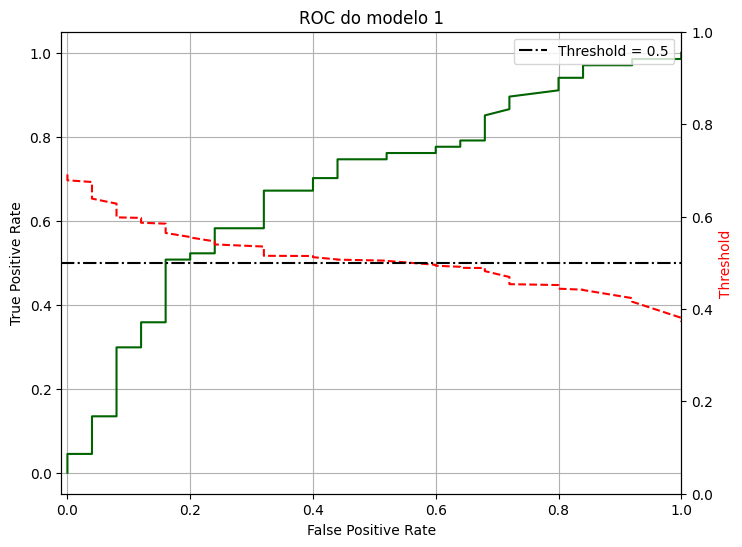

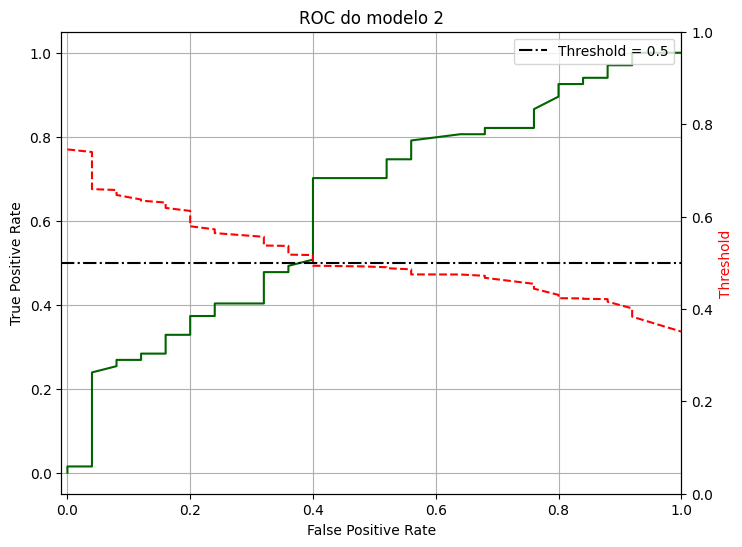

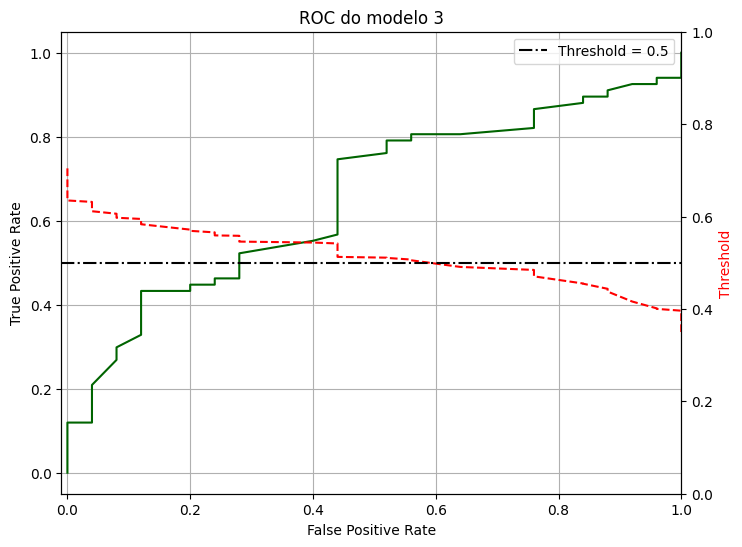

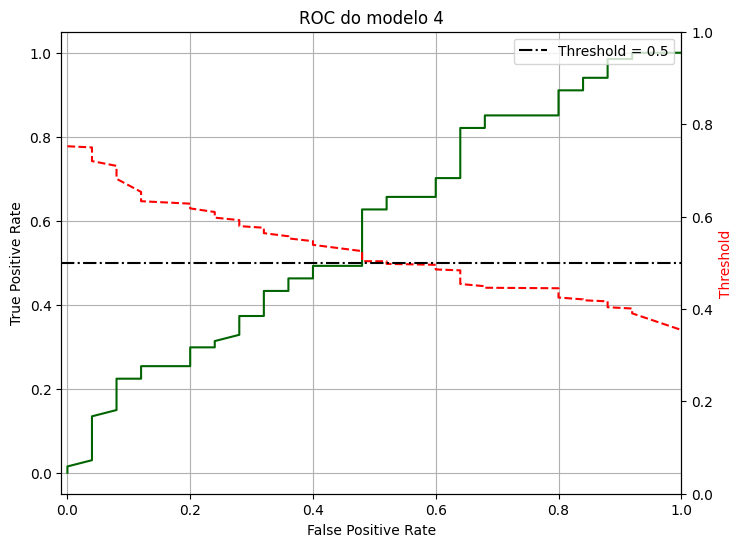

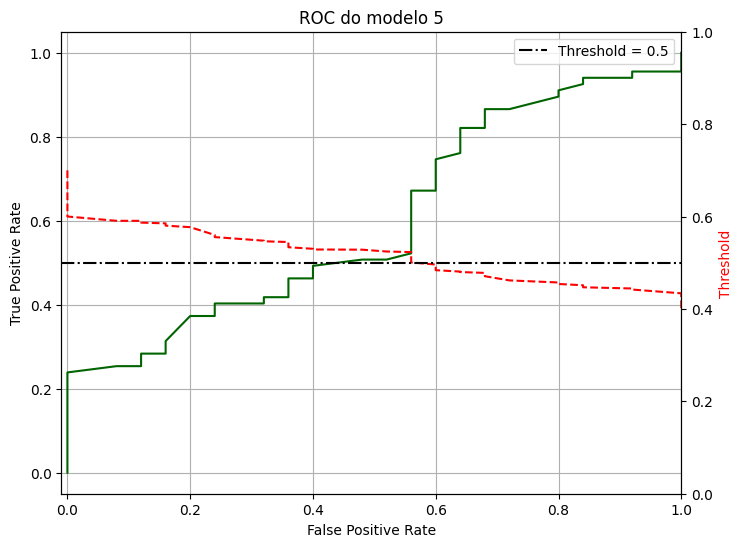

In [75]:
X_test = X_test[X_train.columns]
for i in range(5):
    y_pred_proba = RF[i].predict_proba(X_test)[::,1]
    fpr, tpr, sarrafo = roc_curve(y_test,  y_pred_proba)
    sarrafo = sarrafo[fpr <= 1]
    
    #create ROC curve
    plt.figure(figsize = (8,6))
    plt.plot(fpr,tpr, lw = 1.5, color = "darkgreen")
    plt.grid()
    plt.title(f"ROC do modelo {i + 1}")
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    ax2 = plt.gca().twinx()
    ax2.plot(fpr, sarrafo, markeredgecolor='r',linestyle='dashed', color='r')
    ax2.set_ylabel('Threshold',color='r')
    ax2.set_ylim([0,1])
    ax2.set_xlim([-0.01,1])
    ax2.axhline(y = 0.5, lw = 1.5, color = "black", ls = "-.", label = "Threshold = 0.5")
    plt.legend()

    plt.show()

In [76]:
for i in range(5):
    scores = [accuracy_score(y_test, RF[i].predict(X_test)), 
                             balanced_accuracy_score(y_test, RF[i].predict(X_test)), 
                             f1_score(y_test, RF[i].predict(X_test), average = "macro"), 
                             precision_score(y_test, RF[i].predict(X_test)), 
                             roc_auc_score(y_test, RF[i].predict(X_test))]
    scores_names = ["Acurácia", "Acurácia_balanceada", "F1_macro", "Precisão", "ROC"]
    
    print("Modelo", i + 1)
    print(pd.DataFrame([scores], columns = scores_names))

Modelo 1
   Acurácia  Acurácia_balanceada  F1_macro  Precisão       ROC
0  0.684783             0.620597  0.615728  0.796875  0.620597
Modelo 2
   Acurácia  Acurácia_balanceada  F1_macro  Precisão       ROC
0  0.619565             0.613433   0.58371  0.807692  0.613433
Modelo 3
   Acurácia  Acurácia_balanceada  F1_macro  Precisão       ROC
0  0.706522             0.622985   0.62449  0.794118  0.622985
Modelo 4
   Acurácia  Acurácia_balanceada  F1_macro  Precisão       ROC
0  0.586957             0.553433  0.537811  0.763636  0.553433
Modelo 5
   Acurácia  Acurácia_balanceada  F1_macro  Precisão       ROC
0  0.608696             0.555821  0.546798  0.762712  0.555821


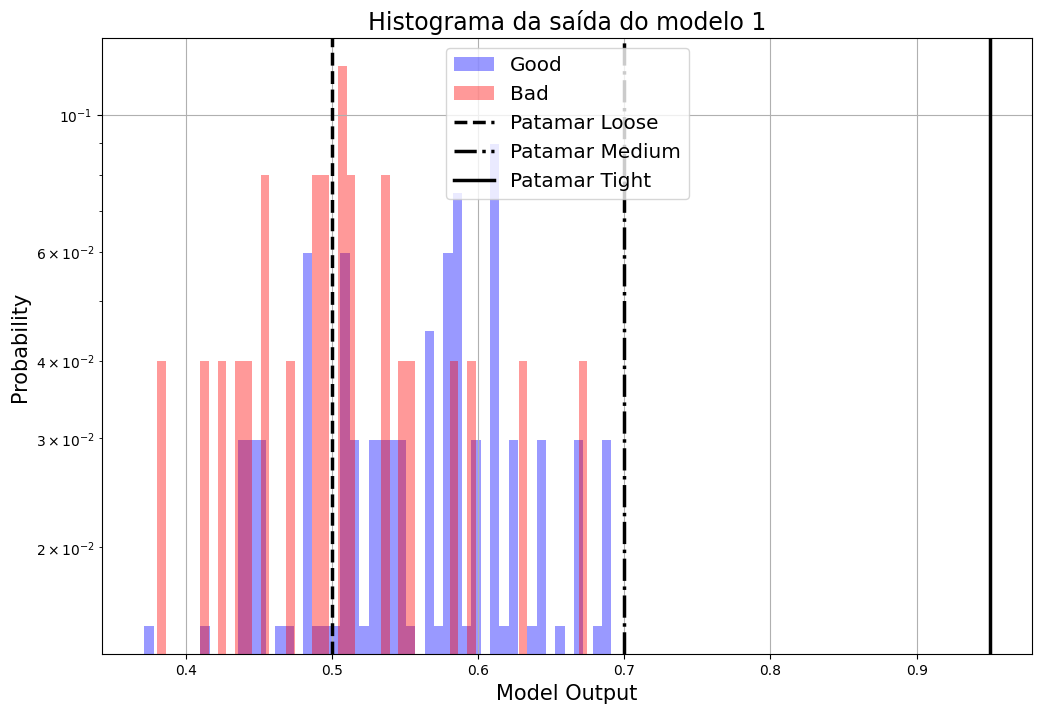

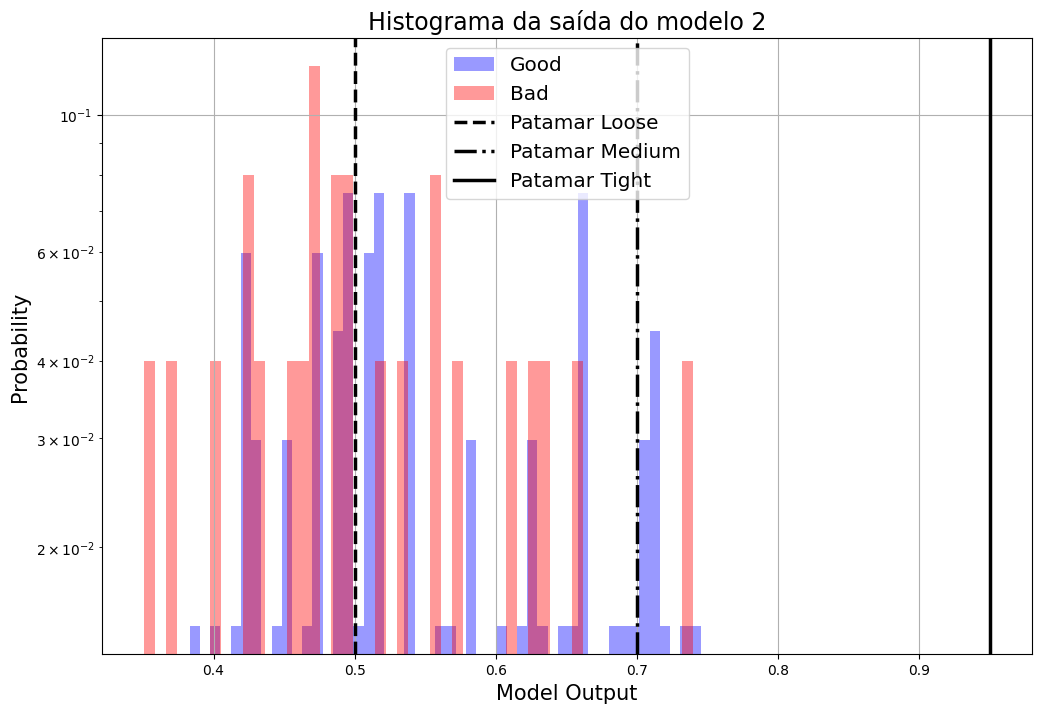

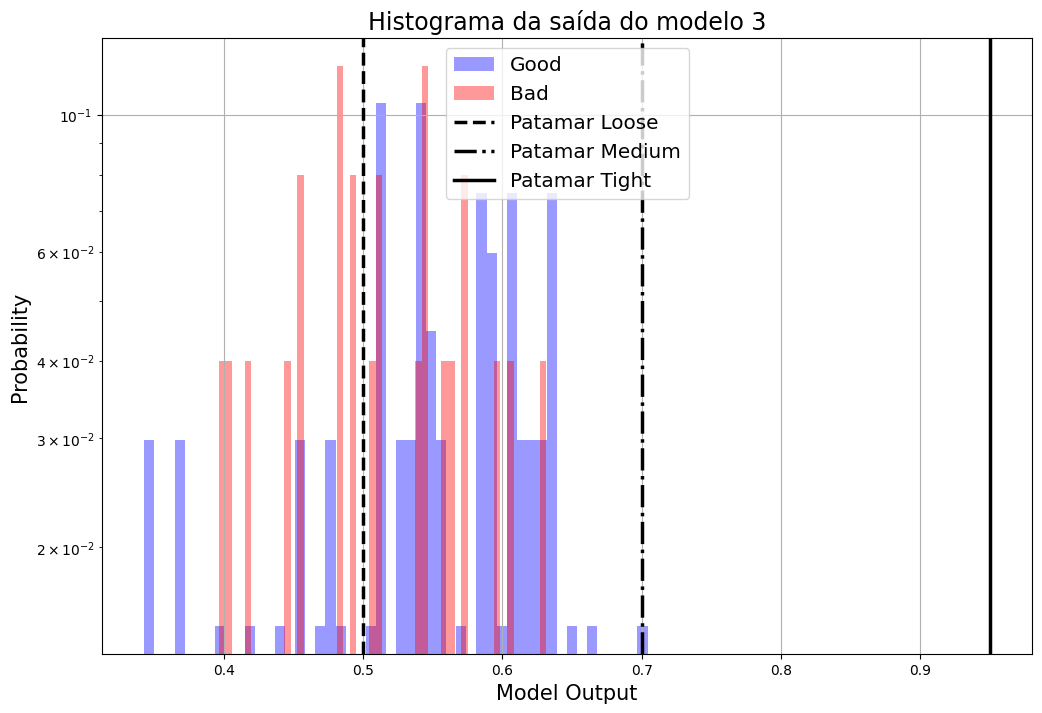

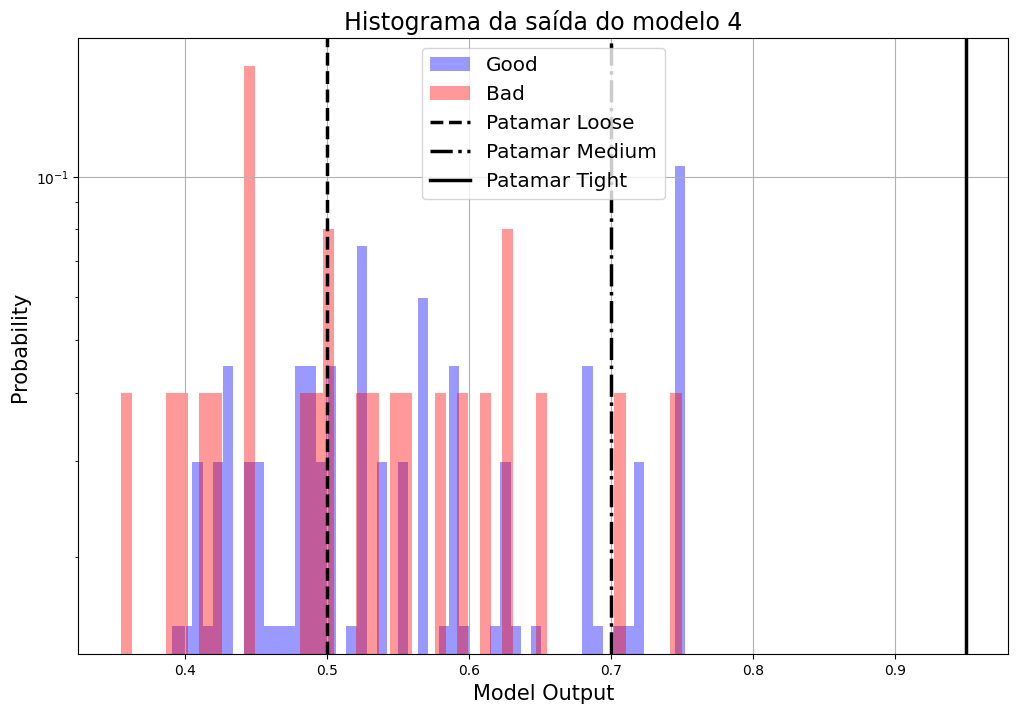

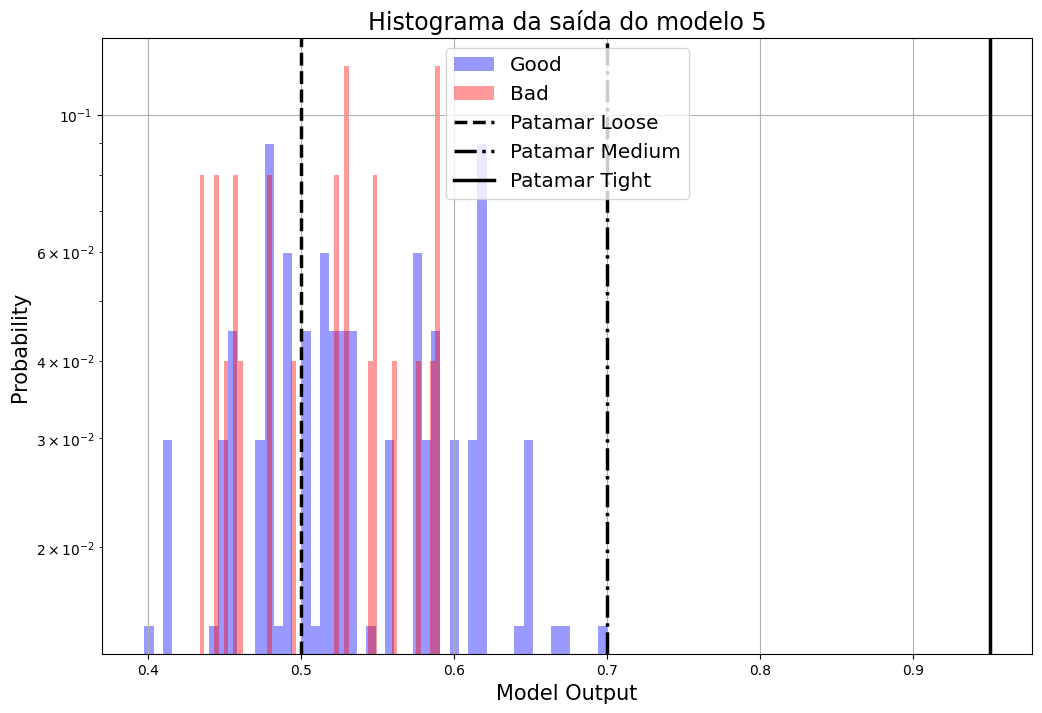

In [77]:
predict_model_cols = X_test.columns

for model_idx in range(5):
    # Separa os valores de teste
    if "probabilidade_model_%i" %(model_idx) not in X_test.columns:
        X_test["probabilidade_model_%i" %(model_idx)] = RF[model_idx].predict_proba(X_test[predict_model_cols])[:,1]
    
    #Figura
    plt.figure(figsize = (12,8))
    # weights for hist 1
    weights_h1 = (np.ones_like(X_test.loc[y_test == 1, "probabilidade_model_%i" %(model_idx)].values)/\
                  len(X_test.loc[y_test == 1, "probabilidade_model_%i" %(model_idx)]))
    # weights for hist 2
    weights_h2 = (np.ones_like(X_test.loc[y_test != 1, "probabilidade_model_%i" %(model_idx)].values)/\
                  len(X_test.loc[y_test != 1, "probabilidade_model_%i" %(model_idx)]))

    plt.hist(X_test.loc[y_test == 1, "probabilidade_model_%i" %(model_idx)], 
             label='Good', weights=weights_h1,
             color='blue', bins=50, histtype='stepfilled', lw=1.5, alpha=.4)
    plt.hist(X_test.loc[y_test != 1, "probabilidade_model_%i" %(model_idx)], 
             label='Bad', weights=weights_h2, 
             color='red', bins=50, histtype='stepfilled', lw=1.5, alpha=.4)
    #sns.histplot(x = x_test["probabilidade de pagar"],
    #             hue = y_test)
    plt.ylabel('Probability', fontsize=15)
    plt.xlabel('Model Output', fontsize=15)
    plt.grid()
    plt.title(f"Histograma da saída do modelo {model_idx+1}", fontsize=17) 
    plt.axvline(x=.5, color='black', lw=2.5, ls='--', label='Patamar Loose')
    plt.axvline(x=.7, color='black', lw=2.5, ls='-.', label='Patamar Medium')
    plt.axvline(x=.95, color='black', lw=2.5, ls='-', label='Patamar Tight')
    plt.legend(loc='upper center', fontsize='x-large')
    plt.yscale('log')
    plt.show()

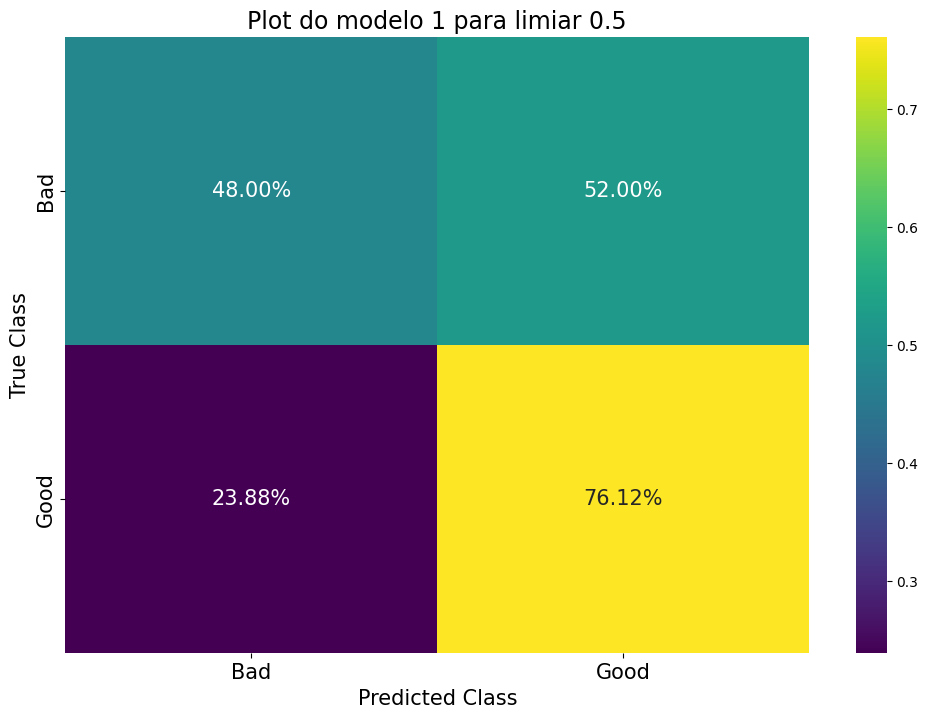

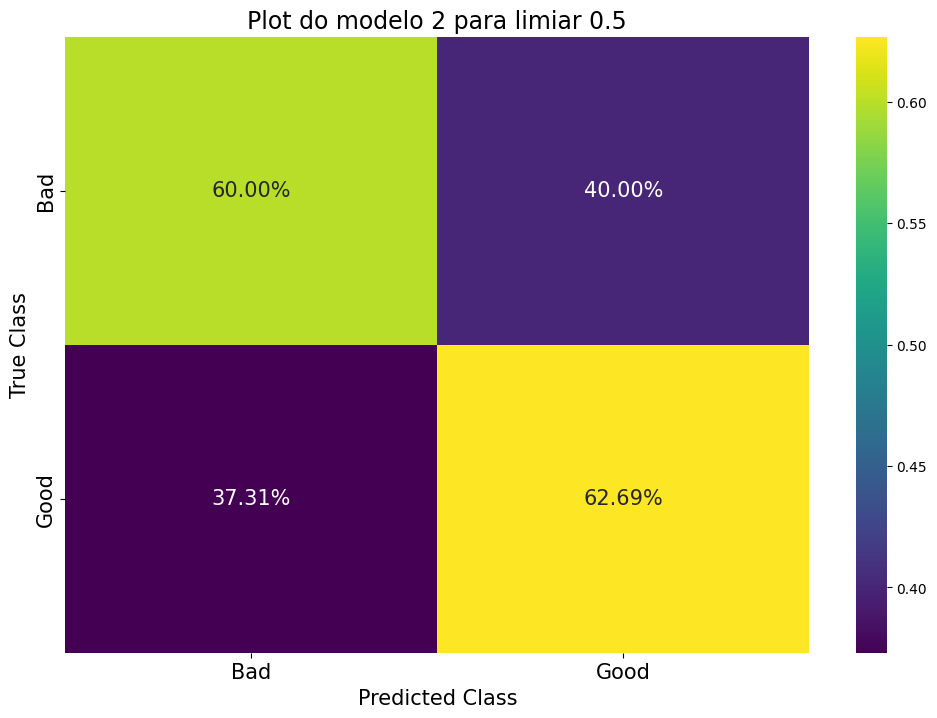

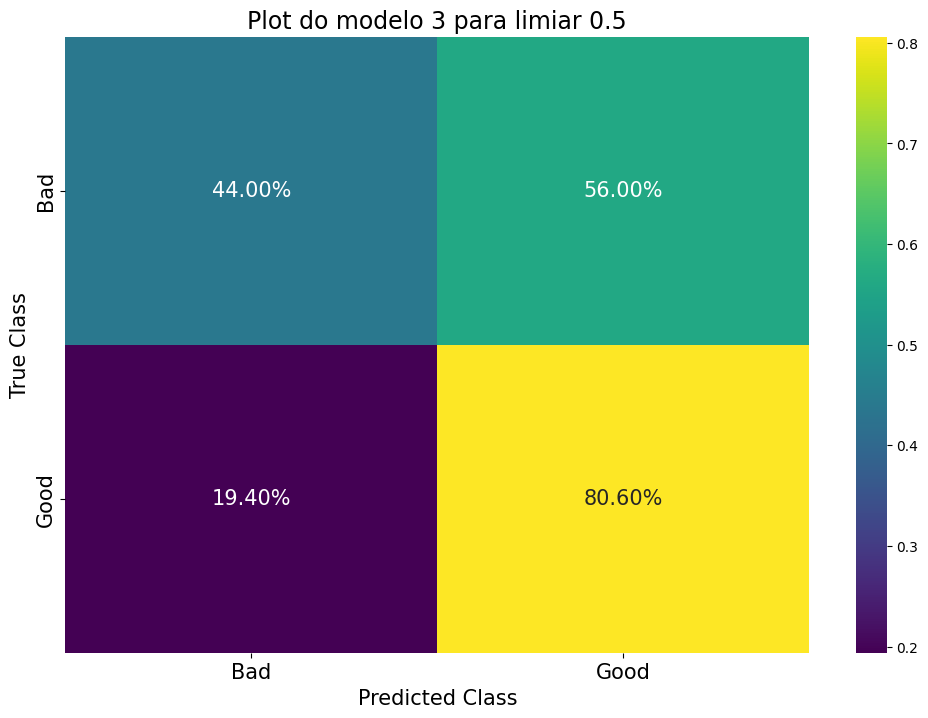

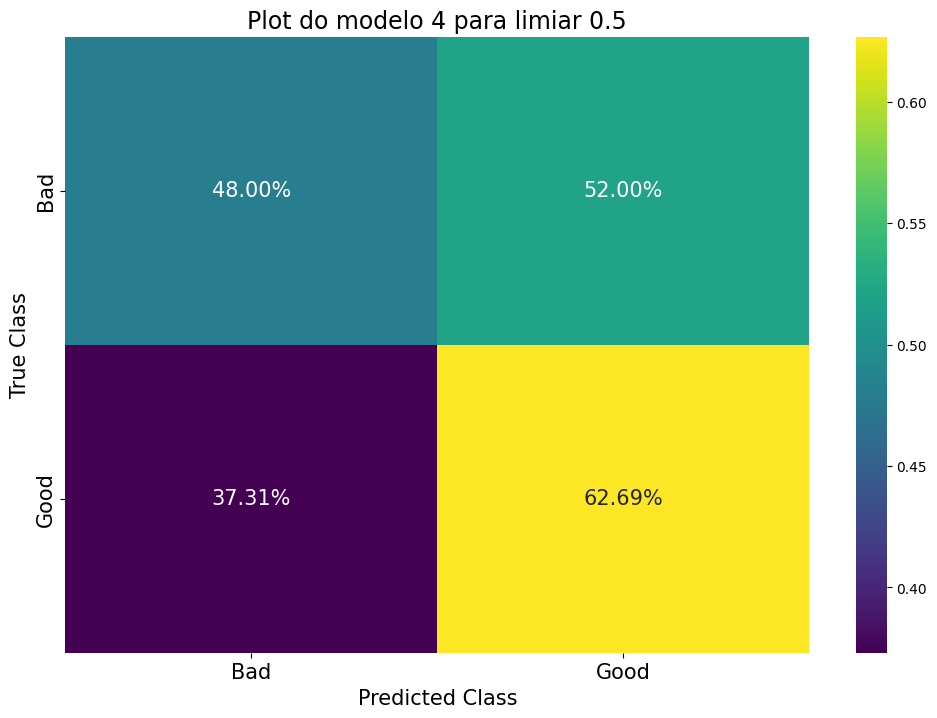

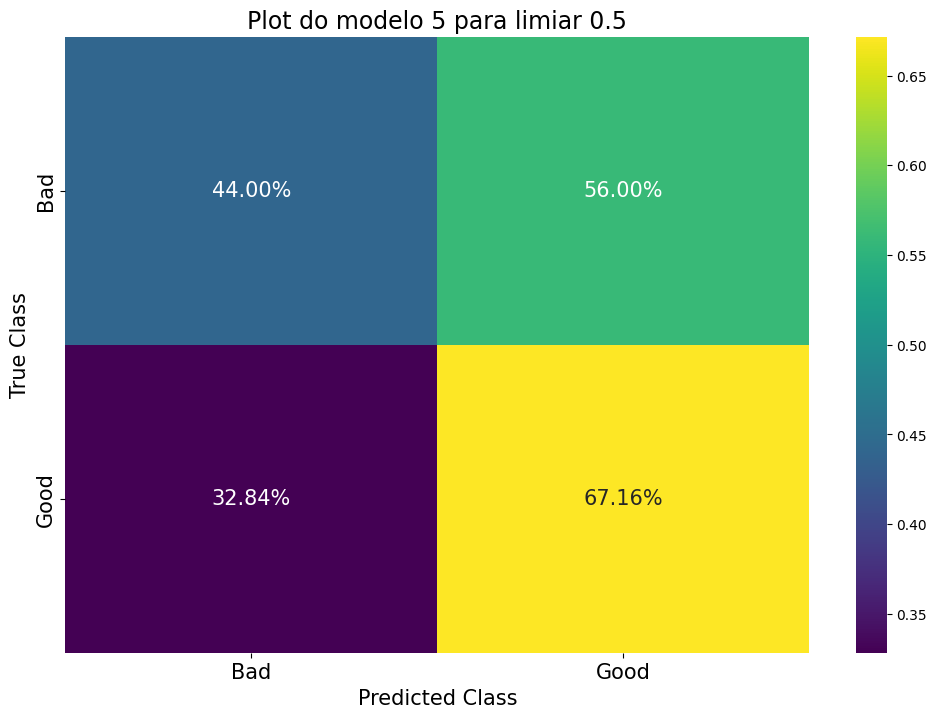

In [78]:
for i in range(5):
    plt.figure(figsize = (12,8))
    matriz = confusion_matrix(y_test, RF[i].predict(X_test[predict_model_cols]), normalize = "true")
    ax = sns.heatmap(matriz, cmap = "viridis", annot = True, annot_kws={"fontsize":15}, fmt=".2%")
    ax.set_title(f"Plot do modelo {i+1} para limiar 0.5", fontsize=17)
    ax.set_ylabel("True Class", fontsize=15)
    ax.set_xlabel("Predicted Class", fontsize=15)
    ax.set_xticklabels(["Bad", "Good"], fontsize=15)
    ax.set_yticklabels(["Bad", "Good"], fontsize=15)
    plt.show()
    "/n"